In [56]:
import sys
import os
import pandas as pd
import numpy as np
import copy 
sys.path.insert(1, '..')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
color = sns.color_palette()
sns.set_style("dark")
sns.set_context('talk')

# Functions

In [3]:
def compute_clean(df):
    ''' Appends additional column to dataframe which is 1 if no toxic label, 0 otherwise
    '''
    targets = [u'toxic', u'severe_toxic', u'obscene', u'threat', u'insult', u'identity_hate']
    df = df.copy()
    rowsums = df.loc[:,targets].sum(axis=1)
    df['clean'] = (rowsums == 0)
    return df

In [54]:
def process_text(text):
    """
    Applies a pipeline of preprocessing steps to the input string
    :param text: String which represents a document
    :return: Preprocessed string
    """
    text = copy.deepcopy(text)

    # tokenize text
    text = word_tokenize(text, language='english')

    # remove punctuation and numbers
    text = [word for word in text if word.isalpha()]

    # lower case text
    text = [word.lower() for word in text]

    # remove stop words
    text = [w for w in text if not w in stopwords.words('english')]

    return text

# Load data and inspect 

In [4]:
data_dir = '../data/external/'
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))

In [5]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
print(train_df.shape)
print(test_df.shape)

(159571, 8)
(153164, 2)


Size of train and test is similar

In [8]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [9]:
test_df.isnull().sum()

id              0
comment_text    0
dtype: int64

# Exploration

In [10]:
# Compute additional column which flags whether text is clean (i.e., no toxic flags)
train_df = compute_clean(train_df)
train_df.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True


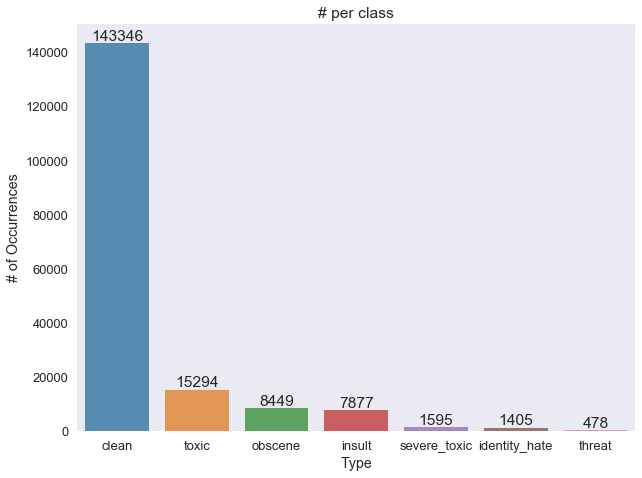

In [11]:
x = train_df.iloc[:,2:].sum()
x.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(10,7.5))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences')
plt.xlabel('Type')

# Adding text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, int(label), ha='center', va='bottom')

plt.show()

Dataset is highly imbalanced

In [12]:
x = rowsums.value_counts()

#plot
plt.figure(figsize=(10,7.5))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences')
plt.xlabel('# of tags ')

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

NameError: name 'rowsums' is not defined

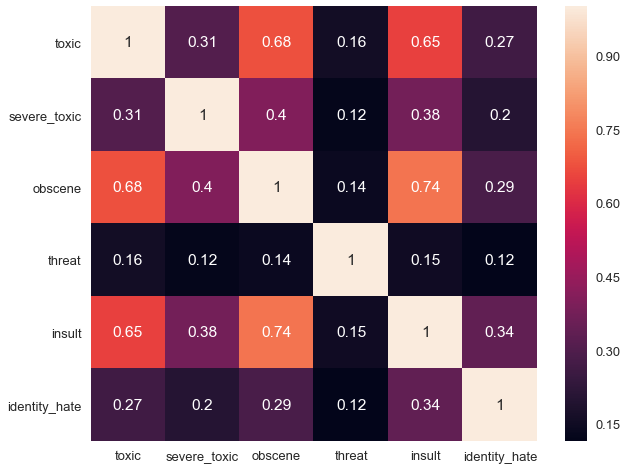

In [13]:
temp_df = train_df.iloc[:,2:-1]

corr = temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

# Explore text

## Comment length distribution

Text(0.5,1,'Distribution of comment lengths')

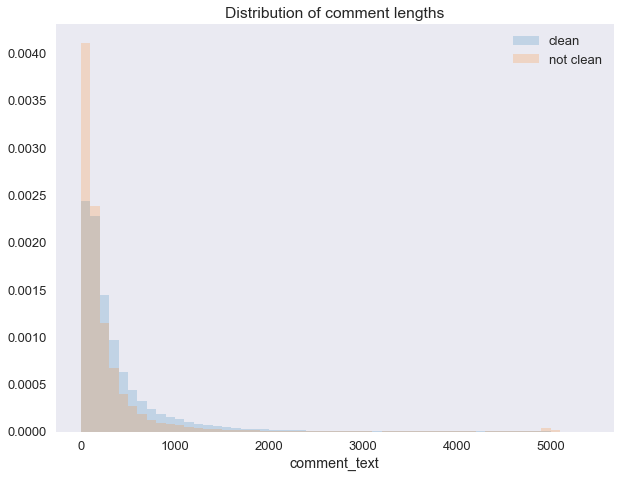

In [14]:
ax, fig = plt.subplots(figsize=[10,7.5])
sns.distplot(train_df[train_df.clean].comment_text.str.len(), 
             kde=False,
             bins=np.arange(0,5500,100),
             norm_hist=True,
             hist_kws={'alpha':0.2},
             label='clean')

sns.distplot(train_df[~train_df.clean].comment_text.str.len(),
             kde=False,
             bins=np.arange(0,5500,100),
             norm_hist=True, 
             hist_kws={'alpha':0.2},
             label='not clean')

plt.legend()
plt.title('Distribution of comment lengths')

Not-clean comments look shorter than clean comments. Appears to be a slight peak in the not-clean comments at around comment length of 5000.

## Most frequent words

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords

In [81]:
corpus = train_df[~train_df.clean].comment_text.add(' ').sum()
corpus_tokenized = process_text(corpus)
freq = FreqDist(corpus_tokenized)
df_freq = pd.Series(dict(freq.most_common(100)))

In [86]:
sys.getsizeof(corpus) / 1e6

19.749408

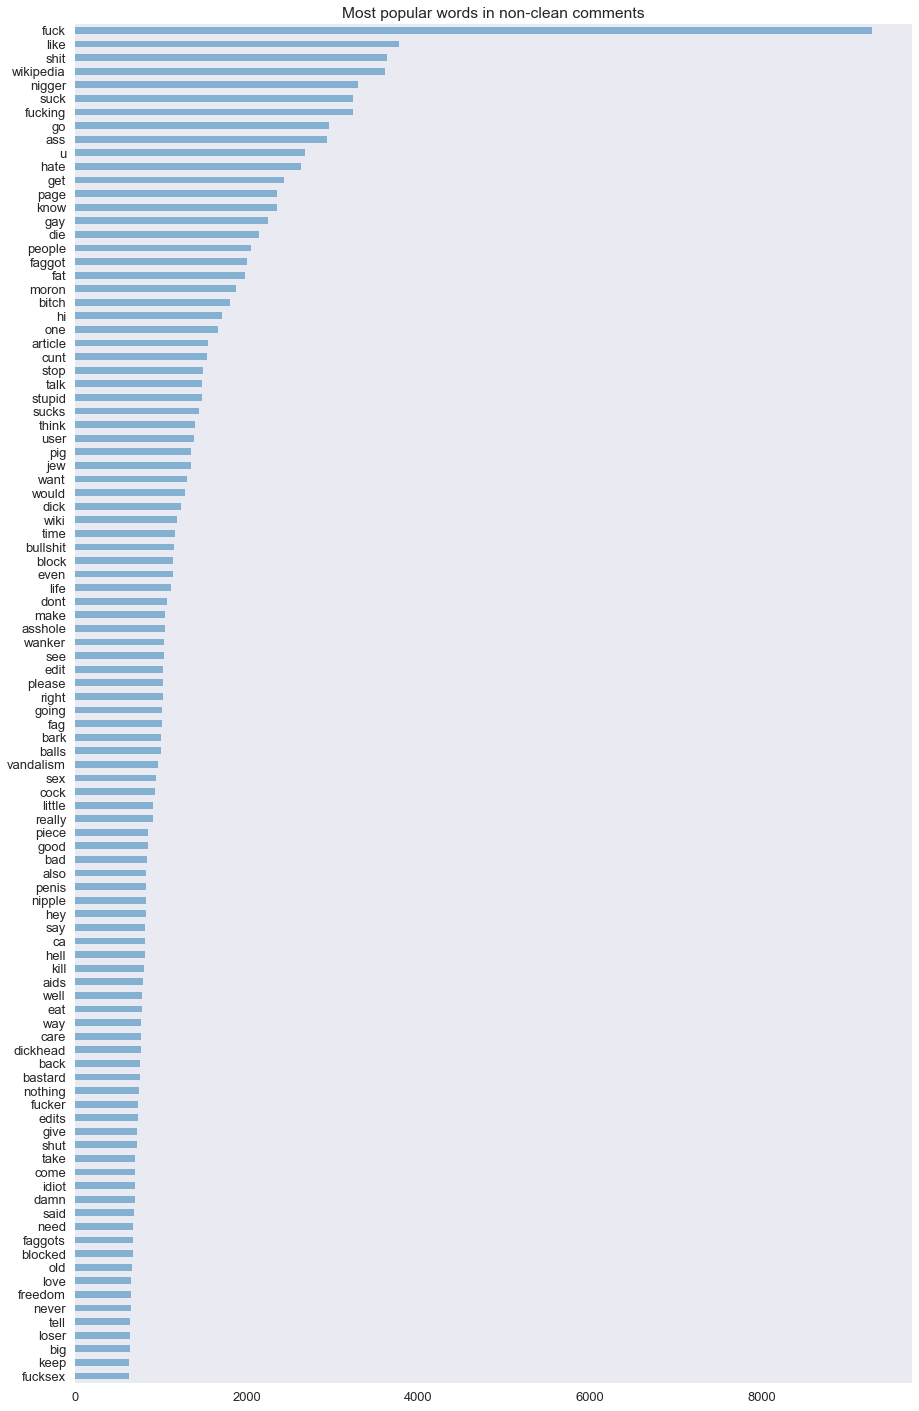

In [87]:
fig, ax = plt.subplots(figsize=[15, 25])
df_freq.sort_values(ascending=False).plot(kind='barh',ax = ax, color=color[0], alpha=0.5)
ax.invert_yaxis()
ax.set_title('Most popular words in non-clean comments')
fig.savefig('../reports/figures/most_popular_words_not_clean.png')